In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(ComplexUpset)
library(repr)
library(ggridges)


Lade n"otiges Paket: SeuratObject

Lade n"otiges Paket: sp



'SeuratObject' was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall 'SeuratObject' as the ABI
for R may have changed

'SeuratObject' was built with package 'Matrix' 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attache Paket: 'SeuratObject'


Das folgende Objekt ist maskiert 'package:base':

    intersect




In [2]:
library(extrafont)
font_import(paths = "/Library/Fonts", prompt = FALSE)
loadfonts()
fonts()


Registering fonts with R

Scanning ttf files in /Library/Fonts ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf
 : ArialUnicodeMS already registered in fonts database. Skipping.

/Library/Fonts/FontsFree-Net-MYRIADPRO-REGULAR.ttf
 : MyriadPro-Regular already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library/extrafontdb/metrics

Arial Unicode MS already registered with pdfFont().

Myriad Pro already registered with pdfFont().

Arial Unicode MS already registered with postscriptFont().

Myriad Pro already registered with postscriptFont().



[1] "Arial Unicode MS" "Myriad Pro"

In [3]:
# Change plot size to 15 x 8
options(repr.plot.width = 15, repr.plot.height = 8)


## Ridge plot from HTODemux result


In [4]:
# Load htodemux result from an rds object
htodemux_gx12 <- readRDS("../data/pipeline_output/gx12/htodemux.rds")


In [5]:
# Rename features
htodemux_gx12@assays$HTO@counts@Dimnames[[1]] <-
    paste0("Hash45", 1:6)
rownames(htodemux_gx12@assays$HTO@data) <- paste0("Hash45", 1:6)
rownames(htodemux_gx12@assays$HTO@meta.features) <-
    paste0("Hash45", 1:6)
htodemux_gx12@meta.data$HTO_maxID <-
    gsub("-TotalSeqA", "", htodemux_gx12@meta.data$HTO_maxID)
htodemux_gx12 <- RenameIdents(
    htodemux_gx12,
    "Hash453-TotalSeqA" = "Hash453",
    "Hash451-TotalSeqA" = "Hash451",
    "Hash452-TotalSeqA" = "Hash452",
    "Hash454-TotalSeqA" = "Hash454",
    "Hash455-TotalSeqA" = "Hash455",
    "Hash456-TotalSeqA" = "Hash456"
)


In [6]:
rp <- RidgePlot(
    htodemux_gx12,
    assay = "HTO",
    idents = paste0("Hash45", 1:6),
    features = paste0("Hash45", 1:6),
    ncol = 3,
    cols = c("#6BAED6", "#A6D854", "#FC8D62", "#E5C494", "#B3B3B3")
)
for (i in 1:6) {
    rp[[i]] <-
        rp[[i]] + theme_ridges(font_size = 20, font_family = "Myriad Pro") +
        theme(legend.position = "none") + ylab("") # grid = FALSE)
}


Picking joint bandwidth of 0.0588

Picking joint bandwidth of 0.0424

Picking joint bandwidth of 0.0367

Picking joint bandwidth of 0.0448

Picking joint bandwidth of 0.0151

Picking joint bandwidth of 0.0347



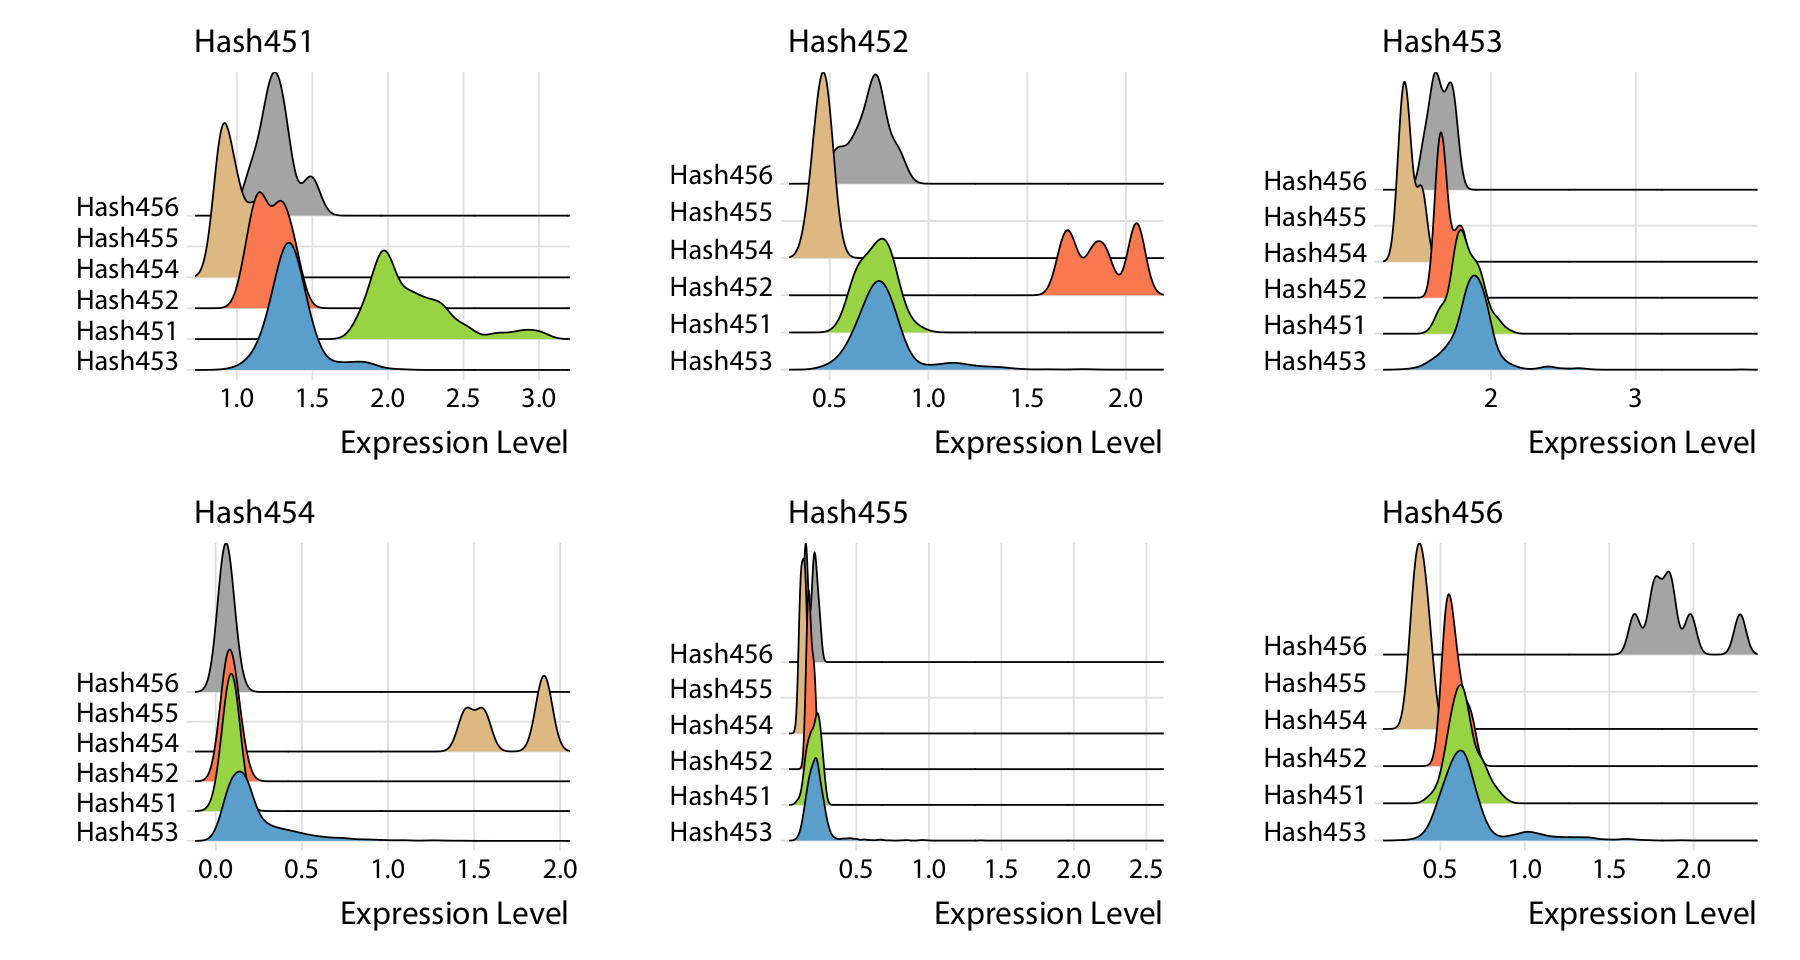

In [7]:
rp
# ggsave("s1/ridge-gx12.pdf", width = 15, height = 8, dpi = 300)


### Load hashing deconvolution results


In [8]:
# Load hashing deconvolution results
hash_gx12_classi <-
    fread("../data/pipeline_output/gx12/hash_classification_all.csv",
        na.strings = ""
    )

# Remove the trial ID
colnames(hash_gx12_classi) <-
    gsub("_1", "", colnames(hash_gx12_classi))

# Subset by only those cells detected by RNA
white_list_gx12 <-
    fread("../data/dataset/barcodes_gx12.tsv", header = FALSE)$V1
hash_gx12_classi <- hash_gx12_classi[Barcode %in% white_list_gx12, ]

# remove result of Solo
hash_gx12_classi <- hash_gx12_classi[, -7]
colnames(hash_gx12_classi) <-
    c(
        "Barcode",
        "DemuxEM",
        "HashedDrops",
        "HashSolo",
        "HTODemux",
        "Multiseq",
        "GMM_Demux",
        "BFF"
    )


head(hash_gx12_classi)


Barcode,DemuxEM,HashedDrops,HashSolo,HTODemux,Multiseq,GMM_Demux,BFF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGTGTGAC-1,singlet,negative,singlet,singlet,singlet,negative,doublet
AAACCCAGTGAGAGGG-1,singlet,NA,singlet,negative,doublet,negative,doublet
AAACGAAAGAATCTAG-1,negative,negative,singlet,negative,negative,negative,doublet
AAACGAACACATATGC-1,singlet,negative,singlet,negative,negative,negative,doublet
AAACGAACACGACTAT-1,singlet,negative,singlet,singlet,singlet,negative,doublet
AAACGAACATCAGCAT-1,negative,negative,singlet,singlet,negative,negative,doublet


## Upset plot for droplet classification of hashing deconvolution methods

### Turn the assignment into a binary matrix


In [9]:
# table in a long format
hash_gx12_classi_new <- melt(hash_gx12_classi, id.vars = 1)
hash_gx12_classi_new <- na.omit(hash_gx12_classi_new)
head(hash_gx12_classi_new)


Barcode,variable,value
<chr>,<fct>,<chr>
AAACCCAAGGTGTGAC-1,DemuxEM,singlet
AAACCCAGTGAGAGGG-1,DemuxEM,singlet
AAACGAAAGAATCTAG-1,DemuxEM,negative
AAACGAACACATATGC-1,DemuxEM,singlet
AAACGAACACGACTAT-1,DemuxEM,singlet
AAACGAACATCAGCAT-1,DemuxEM,negative


In [10]:
# Subset to singlets
hash_gx12_classi_new_singlet <-
    hash_gx12_classi_new[hash_gx12_classi_new$value == "singlet", ]
hash_gx12_classi_new_singlet <- hash_gx12_classi_new_singlet[, -3]

# table in a wide format
hash_gx12_classi_new_singlet <-
    dcast(hash_gx12_classi_new_singlet, Barcode ~ variable)
hash_gx12_classi_new_singlet <-
    as.data.frame(lapply(hash_gx12_classi_new_singlet[, -1], as.numeric))

# turn into a binary matrix
hash_gx12_classi_new_singlet[!is.na(hash_gx12_classi_new_singlet)] <-
    1
hash_gx12_classi_new_singlet[is.na(hash_gx12_classi_new_singlet)] <-
    0
head(hash_gx12_classi_new_singlet)


Using 'variable' as value column. Use 'value.var' to override



,DemuxEM,HashedDrops,HashSolo,HTODemux,Multiseq,BFF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,1,1,0
2,1,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,1,0,0,0
5,1,0,1,1,1,0
6,0,0,1,1,0,0


### Make the upset plot


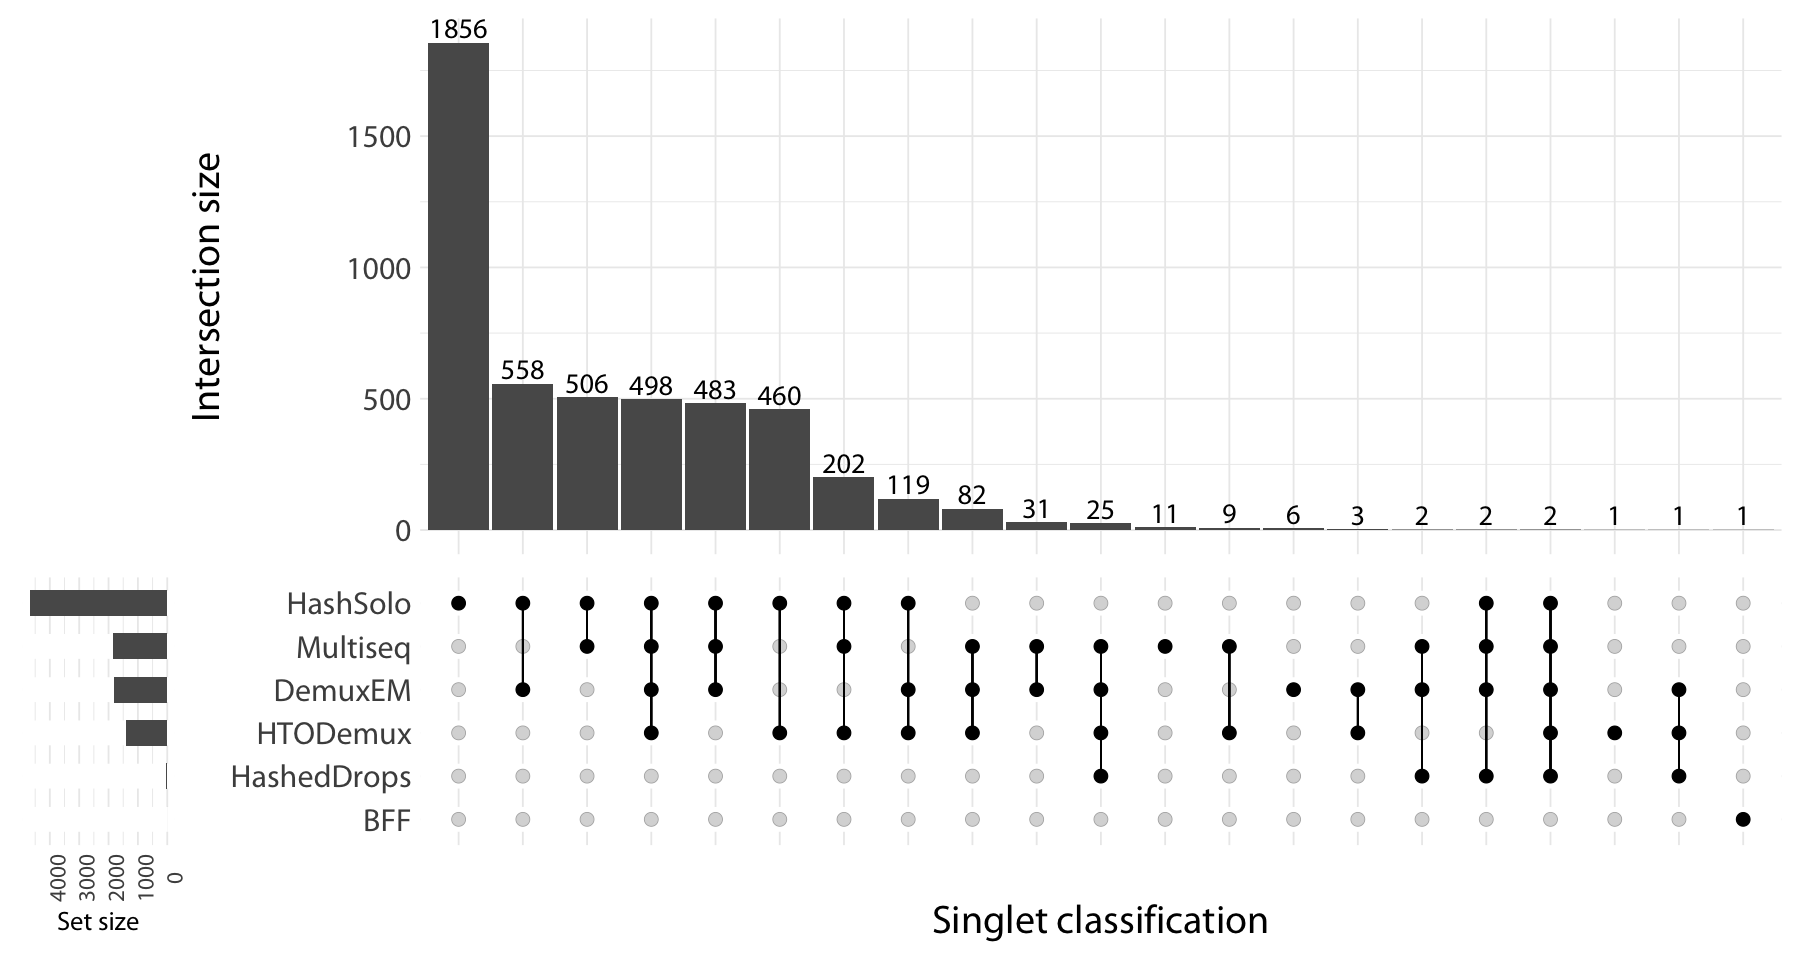

In [11]:
# upset plot
ComplexUpset::upset(
    hash_gx12_classi_new_singlet,
    colnames(hash_gx12_classi_new_singlet),
    width_ratio = 0.1,
    height_ratio = 0.5,
    stripes = "white",
    min_degree = 1,
    name = "Singlet classification",
    set_sizes = (
        upset_set_size() + theme(
            axis.text.x = element_text(angle = 90, size = 14),
            axis.title.x = element_text(size = 16)
        )
    ),
    base_annotations = list(
        "Intersection size" = intersection_size(
            text = list(size = 6, family = "Myriad Pro"),
            width = 0.95,
            bar_number_threshold = 1
        )
    ),
    themes = upset_default_themes(text = element_text(size = 24, family = "Myriad Pro"))
)

# ggsave(
#     "s1/upset-hash-singlet-gx12.pdf",
#     width = 15,
#     height = 8,
#     dpi = 300
# )


In [12]:
# Subset to doublets
hash_gx12_classi_new_doublet <-
    hash_gx12_classi_new[hash_gx12_classi_new$value == "doublet", ]
hash_gx12_classi_new_doublet <- hash_gx12_classi_new_doublet[, -3]

# table in a wide format
hash_gx12_classi_new_doublet <-
    dcast(hash_gx12_classi_new_doublet, Barcode ~ variable)
hash_gx12_classi_new_doublet <-
    as.data.frame(lapply(hash_gx12_classi_new_doublet[, -1], as.numeric))

# turn into a binary matrix
hash_gx12_classi_new_doublet[!is.na(hash_gx12_classi_new_doublet)] <- 1
hash_gx12_classi_new_doublet[is.na(hash_gx12_classi_new_doublet)] <- 0
head(hash_gx12_classi_new_doublet)


Using 'variable' as value column. Use 'value.var' to override



,DemuxEM,HashSolo,HTODemux,Multiseq,GMM_Demux,BFF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,1
2,0,0,0,1,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1
5,0,0,0,0,0,1
6,0,0,0,0,0,1


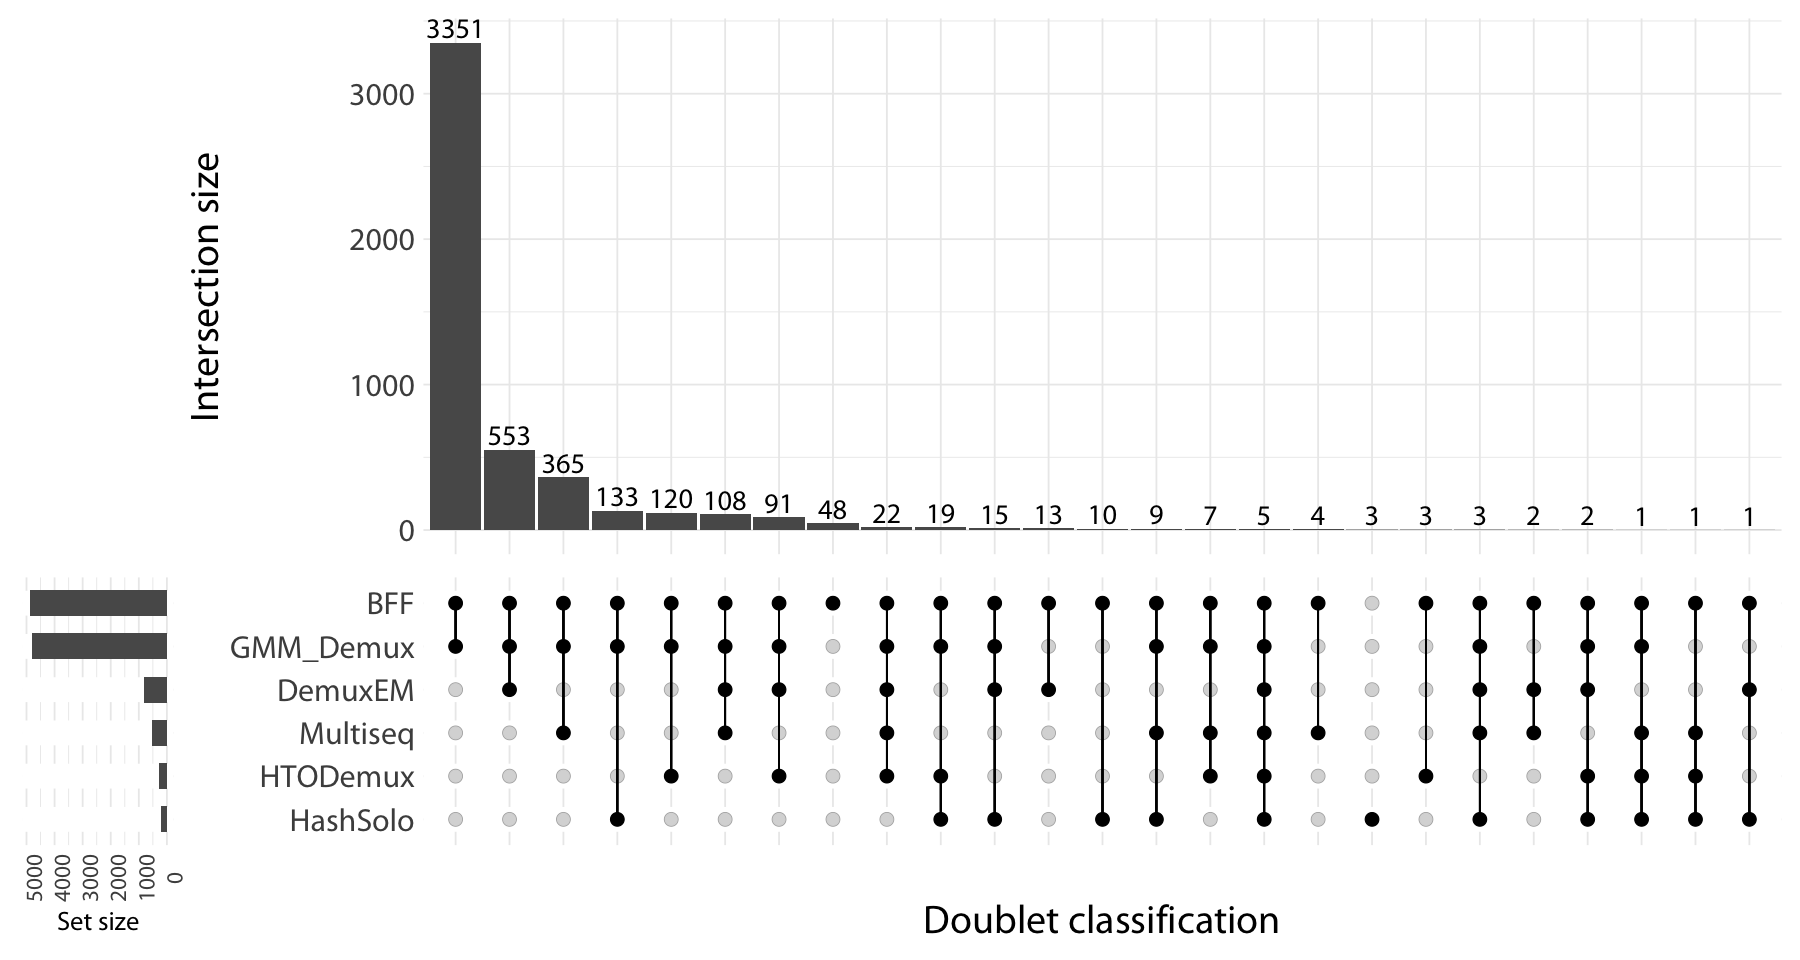

In [13]:
ComplexUpset::upset(
    hash_gx12_classi_new_doublet,
    colnames(hash_gx12_classi_new_doublet),
    width_ratio = 0.1,
    height_ratio = 0.5,
    stripes = "white",
    min_degree = 1,
    name = "Doublet classification",
    set_sizes = (
        upset_set_size() + theme(
            axis.text.x = element_text(angle = 90, size = 14),
            axis.title.x = element_text(size = 16)
        )
    ),
    base_annotations = list(
        "Intersection size" = intersection_size(
            text = list(size = 6, family = "Myriad Pro"),
            width = 0.95,
            bar_number_threshold = 1
        )
    ),
    themes = upset_default_themes(text = element_text(size = 24, family = "Myriad Pro"))
)
# ggsave("s1/upset-hash-doublet-gx12.pdf", width = 15, height = 8, dpi = 300)
